In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.8 MB/s eta 0:00:00
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=8

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import normflows as nf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

RealNVP Implementation Using normflows

In [ ]:
dim = 2
hidden = 64
num_layers = 32

# Base distribution (standard normal)
base = nf.distributions.base.DiagGaussian(dim)

# Define list of flows
flows = []

for i in range(num_layers):
    # MLP takes in 1D input and returns 2D output (scale and shift)
    param_map = nf.nets.MLP([dim // 2, hidden, hidden, dim // 2 * 2], init_zeros=True)

    # Affine coupling block splits input and applies transform to half
    flows.append(nf.flows.AffineCouplingBlock(param_map))

    # Permute dimensions (to alternate which half is transformed)
    flows.append(nf.flows.Permute(dim, mode='swap'))

# Construct the model
model = nf.NormalizingFlow(base, flows)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import json

filename="/content/noisy_moons.json"
with open(filename, 'r') as file:
    data = json.load(file)
Data=torch.tensor(data['X'])

# Compute the mean
mean_x = Data.mean(axis=0)

# Center the data
X_centered = Data - mean_x
x_data = torch.tensor(X_centered, dtype=torch.float32).to(device)

/tmp/ipython-input-5-997784776.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(X_centered, dtype=torch.float32).to(device)


100%|██████████| 800/800 [01:04<00:00, 12.40it/s]


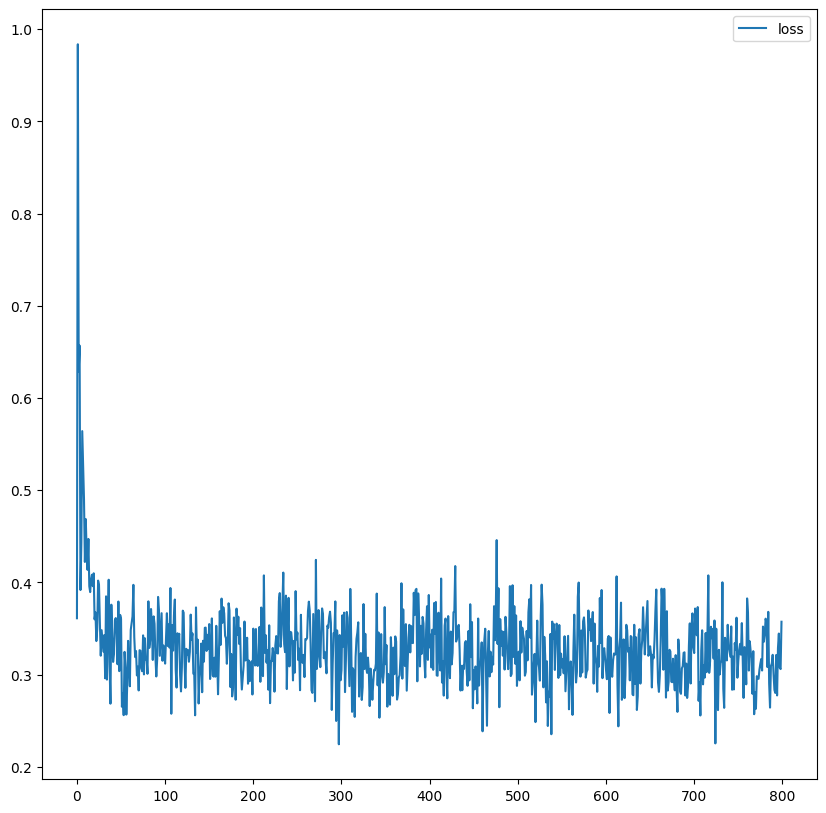

In [ ]:
# Train model
max_iter = 800
num_samples = 2 ** 9
show_iter = 40


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    indices = torch.randperm(X_centered.size(0))[:num_samples]

    # Select the sampled points using the generated indices
    x = X_centered[indices].to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())


# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    z = model.inverse(X_centered)  # RealNVP supports forward()

In [ ]:
z_samples = model.q0.sample(10000)
x_generated = model(z_samples).detach().numpy()

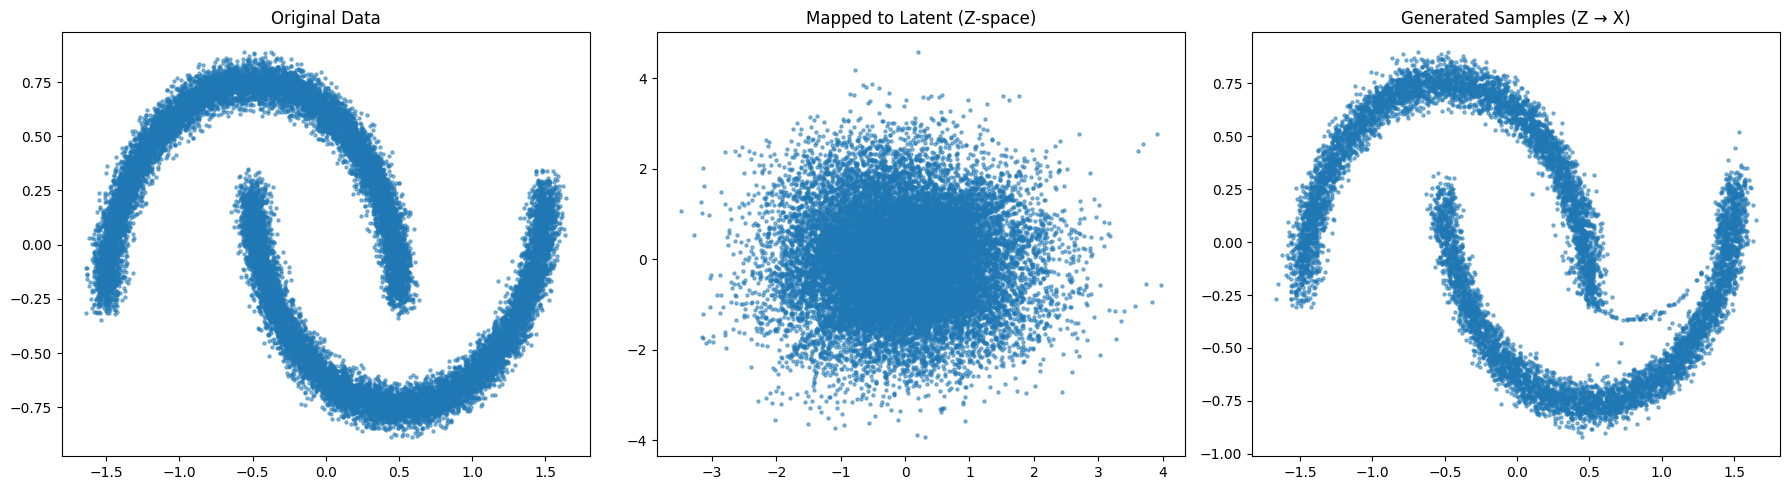

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(X_centered[:, 0], x_data[:, 1], s=5, alpha=0.5)
axs[0].set_title("Original Data")

axs[1].scatter(z[:, 0], z[:, 1], s=5, alpha=0.5)
axs[1].set_title("Mapped to Latent (Z-space)")

axs[2].scatter(x_generated[:, 0], x_generated[:, 1], s=5, alpha=0.5)
axs[2].set_title("Generated Samples (Z → X)")

plt.tight_layout()
plt.show()

In [ ]:
dim = 2
hidden = 128
num_layers = 32

# Base distribution (standard normal)
base = nf.distributions.base.DiagGaussian(dim)

# Define list of flows
flows = []

for i in range(num_layers):
    # MLP takes in 1D input and returns 2D output (scale and shift)
    param_map = nf.nets.MLP([dim // 2, hidden, hidden, dim // 2 * 2], init_zeros=True)

    # Affine coupling block splits input and applies transform to half
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # flows.append(nf.flows.MaskedAffineAutoregressive(2, hidden, use_batch_norm=True))
    # flows.append(nf.flows.Radial(2))
    # Permute dimensions (to alternate which half is transformed)
    flows.append(nf.flows.Permute(dim, mode='swap'))

# Construct the model
model2 = nf.NormalizingFlow(base, flows)

In [ ]:
import json

filename="/content/noisy_circles.json"
with open(filename, 'r') as file:
    data = json.load(file)
Data=torch.tensor(data['X'])

# Compute the mean
mean_x = Data.mean(axis=0)

# Center the data
X_centered = Data - mean_x
x_data = torch.tensor(X_centered, dtype=torch.float32).to(device)

/tmp/ipython-input-51-1613076807.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(X_centered, dtype=torch.float32).to(device)


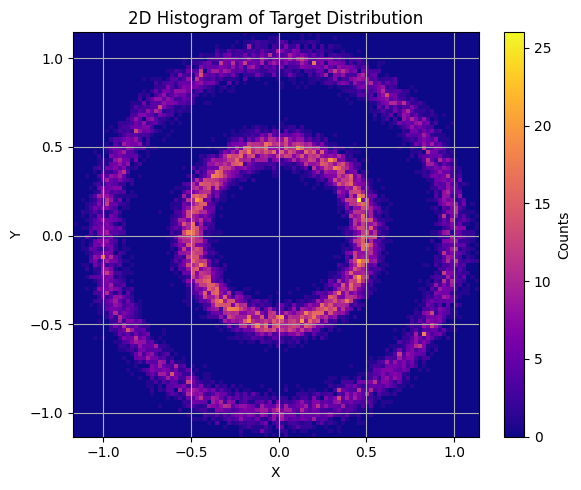

In [ ]:
# Convert to NumPy
data = X_centered.numpy()

# Extract x and y
x = data[:, 0]
y = data[:, 1]

# Plot 2D histogram
plt.figure(figsize=(6, 5))
plt.hist2d(x, y, bins=100, cmap='plasma')  # You can adjust 'bins' and 'cmap'
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram of Target Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

100%|██████████| 1200/1200 [04:25<00:00,  4.52it/s]


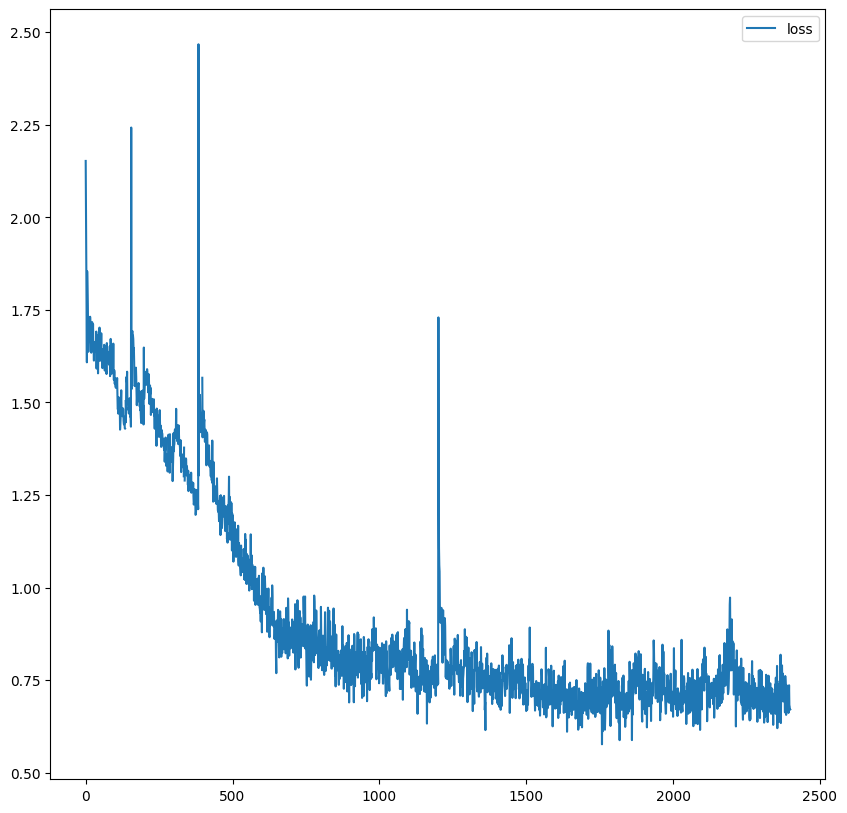

In [ ]:
# Train model
max_iter = 1200
num_samples = 2 ** 9
# show_iter = 40


# loss_hist = np.array([])

optimizer = torch.optim.Adam(model2.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    indices = torch.randperm(X_centered.size(0))[:num_samples]

    # Select the sampled points using the generated indices
    x = X_centered[indices].to(device)

    # Compute loss
    loss = model2.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())


# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    z = model2.inverse(X_centered)  # RealNVP supports forward()

In [ ]:
z_samples = model2.q0.sample(10000)
x_generated = model2(z_samples).detach().numpy()

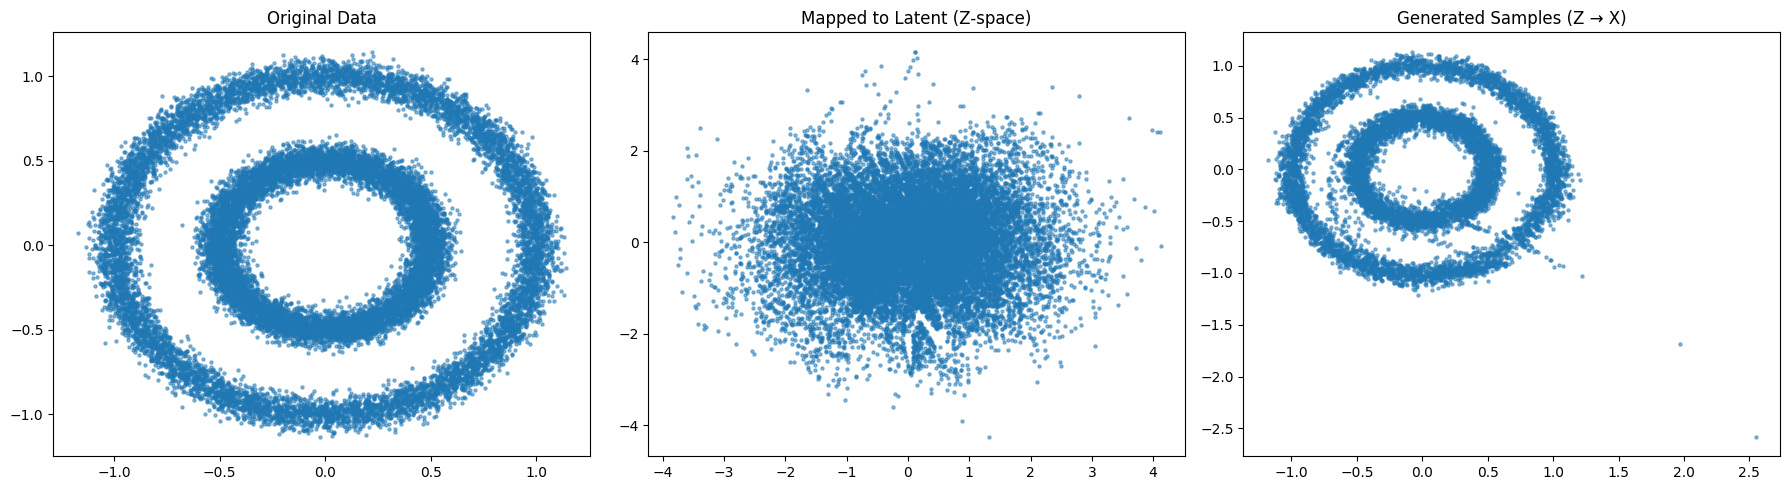

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(X_centered[:, 0], x_data[:, 1], s=5, alpha=0.5)
axs[0].set_title("Original Data")

axs[1].scatter(z[:, 0], z[:, 1], s=5, alpha=0.5)
axs[1].set_title("Mapped to Latent (Z-space)")

axs[2].scatter(x_generated[:, 0], x_generated[:, 1], s=5, alpha=0.5)
axs[2].set_title("Generated Samples (Z → X)")

plt.tight_layout()
plt.show()